In [2]:
# Jupyter Notebook settings

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%autosave 1
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Plotting settings
import matplotlib.pyplot as plt
size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 5}
plt.rcParams.update(params)

from cnnlearning import *
from learningutils import *
from patchextraction import *
from imageprosessing import *
from nearest_neighbors import *
from evaluation import *
from classificationutils import *
from sharedvariables import *
from vesseldetection import *
from generate_datasets import *
from train_model import load_model_from_cache, train_model_demo
from plotutils import plot_images_as_grid
from sharedvariables import get_video_sessions

import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Autosaving every 1 seconds


C:\Users\chadj\Anaconda3\envs\deeplearning\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\chadj\Anaconda3\envs\deeplearning\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Using device: cuda

Using device: cuda



### Create Dataset

patch size (21, 21)
do hist match: True
Negatives per positive: 3

Dataset loading from cache
--------------------------
loading training set from '.\cache\datasets\dataset_ps_21_hm_true_npp_3\trainset_bloodcells_ps_21_hm_true_npp_3.pt'...
loading validation set from '.\cache\datasets\dataset_ps_21_hm_true_npp_3\validset_bloodcells_ps_21_hm_true_npp_3.pt'...
loading bloodcell patches from '.\cache\datasets\dataset_ps_21_hm_true_npp_3\bloodcells_ps_21_hm_true_npp_3.npy'...
loading non bloodcell patches from '.\cache\datasets\dataset_ps_21_hm_true_npp_3\non_bloodcells_ps_21_hm_true_npp_3.npy'...
loading marked bloodcell patches from '.\cache\datasets\dataset_ps_21_hm_true_npp_3\bloodcells_ps_21_hm_true_npp_3_marked.npy'...
loading marked non bloodcell patches from '.\cache\datasets\dataset_ps_21_hm_true_npp_3\non_bloodcells_ps_21_hm_true_npp_3_marked.npy'
loading histogram matching template image (npy array)
Done

Cell images: (14996, 21, 21)
Non cell images (44738, 21, 21)


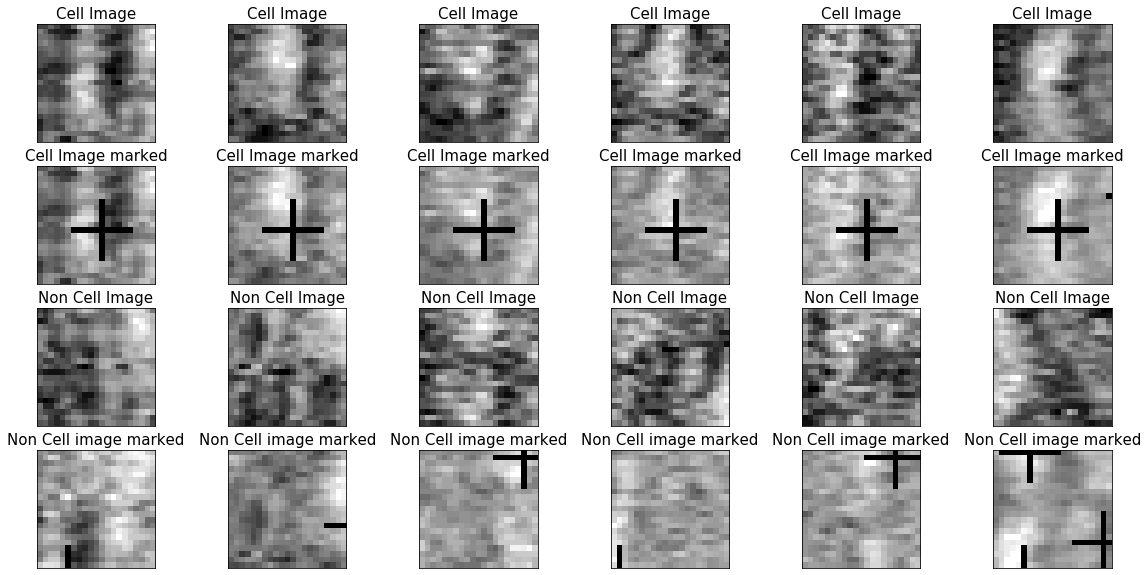

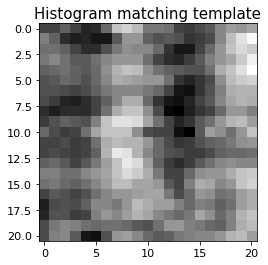

In [3]:
# Input
patch_size=(21, 21)
do_hist_match=True
n_negatives_per_positive=3

overwrite_cache=False
verbose=True
very_verbose=True

### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ###
trainset, validset,\
cell_images, non_cell_images,\
cell_images_marked, non_cell_images_marked, hist_match_template =\
get_cell_and_no_cell_patches(
    patch_size=patch_size,
    n_negatives_per_positive=n_negatives_per_positive,
    do_hist_match=do_hist_match,
    overwrite_cache=overwrite_cache,
    v=verbose,
    vv=very_verbose,
)

print("Cell images:", cell_images.shape)
print("Non cell images", non_cell_images.shape)

fig, axes = plt.subplots(4, 6, figsize=(20, 10))

for ax in axes.flatten():
    ax.tick_params(
        axis='both',
        which='both',
        left=False,       
        right=False,
        labelleft=False,
        bottom=False,
        top=False,
        labelbottom=False)

plt.rcParams['axes.titlesize'] = 15
for ax in axes.flatten():
    ax.tick_params(
        axis='both',
        which='both',
        left=False,       
        right=False,
        labelleft=False,
        bottom=False,
        top=False,
        labelbottom=False)
    
for i, ax in enumerate(axes[0, :]):
    ax.imshow(cell_images[i], cmap='gray')
    ax.set_title('Cell Image')
    

for i, ax in enumerate(axes[1, :]):
    axes[1, i].imshow(cell_images_marked[i], cmap='gray')
    ax.set_title('Cell Image marked')

for i, ax in enumerate(axes[2, :]):
    ax.imshow(non_cell_images[i], cmap='gray')
    ax.set_title('Non Cell Image')
    
for i, ax in enumerate(axes[3, :]):
    ax.imshow(non_cell_images_marked[i], cmap='gray')
    ax.set_title('Non Cell image marked')
    
if do_hist_match:
    plt.figure()
    plt.imshow(hist_match_template, cmap='gray')
    plt.title('Histogram matching template')

##  Create classifier model
Either load model from cache or train a new one.

**You can interrupt**, or Ctr - C at any time to stop training and get the best model at the time.

In [ ]:
# Input
load_model_from_cache = False

train_params = collections.OrderedDict(
    epochs=4000,
    # lr = .001,
    # optimizer=torch.optim.SGD(model.parameters(), lr=.001, weight_decay=5e-5, momentum=0.9),
    optimizer=torch.optim.Adam(model.parameters(), lr=.001, weight_decay=5e-4),
    batch_size=1024 * 7,
    do_early_stop=True,  # Optional default True
    early_stop_patience=80,
    learning_rate_scheduler_patience=100,
    shuffle=True,
    # valid_untrunsformed_normals = valid_untrunsformed_normals,
    trainset=trainset,
    validset=validset)

### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ###
model = train_model_demo(patch_size=patch_size,
                         do_hist_match=do_hist_match, 
                         n_negatives_per_positive=n_negatives_per_positive,
                         load_from_cache=load_model_from_cache,
                         train_params=train_params)

# Model evaluation
## Evaluation on a sample frame

##### Load sample frame

In [ ]:
idx = 3
video_file = unmarked_labeled_video_OA790_filenames[idx]
csv_file = csv_cell_cords_OA790_filenames[idx]
std_image = std_confocal_images_for_labeled_OA790[idx]

assert files_of_same_source(video_file, csv_file)
video_file, csv_file

In [ ]:
frames = get_frames_from_video(video_file)[..., 0]

#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### ####
ground_truth_positions = get_positions_from_csv(csv_file, 1)
sample_frame = frames[0, ...].astype(np.float32) / 255

if do_hist_match:
    sample_frame = np.float32(hist_match(sample_frame, template))

print('Frames shape', frames.shape)
print('Sample frame', sample_frame.shape)
print('Blood cell positions for all frames', all_video_cell_coords.shape)
print()

fig, axes = plt.subplots(1, 2)
axes[0].imshow(sample_frame, cmap='gray')
axes[0].scatter(ground_truth_positions[:, 0], ground_truth_positions[:, 1], label='Manual positions')
axes[0].set_title('Sample frame')
axes[0].legend()

vessel_image = plt.imread(std_image)
axes[1].imshow(vessel_image, cmap='gray')
axes[1].scatter(ground_truth_positions[:, 0], ground_truth_positions[:, 1], label='Manual positions')
axes[1].set_title('Vessel standard deviation image')
axes[1].legend()


fig = plt.gcf()
fig_size = fig.get_size_inches()
fig.set_size_inches((fig_size[0] * 3, fig_size[1] * 3))

sample_frame_cell_patches = extract_patches_at_positions(sample_frame, ground_truth_positions, patch_size=patch_size)

rxs, rys = get_random_point_on_rectangle(ground_truth_positions[:, 0], 
                                         ground_truth_positions[:, 1], 
                                         patch_size)

non_cell_positions = np.array([rxs, rys]).T
remove_positions_too_close_to_border_indices = get_positions_too_close_to_border(non_cell_positions,
                                                                                 image_shape=sample_frame.shape[:2], 
                                                                                 patch_size=patch_size)
non_cell_positions_new = np.delete(non_cell_positions, 
                                   remove_positions_too_close_to_border_indices,
                                   axis=0)

sample_frame_non_cell_patches = extract_patches_at_positions(sample_frame, 
                                                             non_cell_positions_new,
                                                             patch_size=patch_size)

print(sample_frame_cell_patches.shape)
print('Positive accuracy on cells from sample frame:\t\t',
     f'{classify_images(sample_frame_cell_patches, model).sum().item() / len(sample_frame_cell_patches):.3f}')
print('Negative accuracy on non cells from sample frame:\t',
     f'{(1 - classify_images(sample_frame_non_cell_patches, model)).sum().item() / len(sample_frame_non_cell_patches):.3f}')
pass

### Create vessel mask

In [ ]:
from vesseldetection import create_vessel_mask

vessel_image_bordered = cv2.copyMakeBorder(vessel_image, *patch_size, *patch_size, cv2.BORDER_REFLECT)
        
vessel_mask = create_vessel_mask(vessel_image_bordered,
                                 opening_kernel_size=3,
                                 n_iterations=4,
                                 visualise_intermediate_steps=True)
vessel_mask = vessel_mask[patch_size[0]:(vessel_mask.shape[0] - patch_size[0]) ,
                          patch_size[1]:(vessel_mask.shape[1] - patch_size[1])]

In [ ]:
plt.imshow(vessel_mask)

#### Calculate probability map

In [ ]:
@torch.no_grad()
def create_probability_map(image,
                           model,
                           patch_size=(21, 21),
                           padding=cv2.BORDER_REPLICATE,
                           device='cuda',
                           mask=None,
                           ):
    if len(image.shape) == 2:
        # Add channel at end if grayscale. HxW -> HxWx1
        image = image[:, :, np.newaxis]

    # print('Image shape', image.shape)
    # if mask is not None then create patches for every pixel.
    if mask is None:
        mask = np.ones(image.shape[:2], dtype=np.bool)


    model = model.eval()
    model = model.to(device)

    # print('Mask shape', mask.shape)
    # flatten mask to get indices to index patches
    mask_flattened = mask.reshape(-1)
    vessel_pixel_indices = np.where(mask_flattened)[0]

    patches = extract_patches(image, patch_size, padding=padding)[vessel_pixel_indices]
    label_probabilities = label_probability(patches, model, device)

    probability_map = np.zeros(image.shape[:2], dtype=np.float32)
    rows, cols = np.unravel_index(vessel_pixel_indices, probability_map.shape[:2])
    probability_map[rows, cols] = label_probabilities[:, 1]

    return probability_map


probability_map = create_probability_map(sample_frame,
                                         model,
                                         mask=None,
                                         patch_size=patch_size,
                                         device=device)
plt.imshow(probability_map)

## Calculate positions from probability map

* First calculate the best $σ$ for the gaussian blur and the best $H$ for the extended maxima, maximising Dice's coefficient
* Using the best $σ$ and $Η$ find the positions by binarising the image.

In [ ]:
pm = np.uint8(probability_map * 255)
plt.imshow(pm)

In [ ]:
pm_blurred = mh.gaussian_filter(pm, 3)

plt.imshow(pm_blurred)

In [ ]:
gauss_sigmas = np.arange(0.125, 3.25, 0.25)
for s in gauss_sigmas:
    print(s)

In [ ]:
probability_map = pm
pathlib.Path(CACHED_DICE).mkdir(parents=True, exist_ok=True)

filename = os.path.join(CACHED_DICE, 
                        f'blood_cell_dices_coefficient_sigma_h_{patch_size[0]}_hm_{str(do_hist_match).lower()}.csv')
try:
    print(f'Loading dices coefficient and correspoding sigmas and hs from:\n {filename}')
    df = pd.read_csv(filename, usecols=(1, 2, 3))
    print('Done')
except FileNotFoundError:
    print(f"File not found. Finding sigma and h that maximise Dice's coefficient...")
    pd.set_option('display.max_rows', 20)
    dices_coefficients = []
    sigmas = []
    Hs = []

    gauss_sigmas = np.arange(0.125, 3.25, 0.25).astype(np.float32)
    extended_maxima_Hs = np.arange(0, 255, 1).astype(np.uint8)
    from tqdm import tqdm

    max_dices_coeff = 0
    best_sigma = gauss_sigmas[0]
    best_H = extended_maxima_Hs[0]
    c = 0
    for s in tqdm(gauss_sigmas):
        for h in extended_maxima_Hs:
            estimated_positions = get_cell_positions_from_probability_map(probability_map, s, h)

            dices_coeff, _, _ = evaluate_results(ground_truth_positions, 
                                                 estimated_positions,
                                                 sample_frame,
                                                 patch_size=(19, 19))
            if dices_coeff < 0:
                continue
            if dices_coeff > max_dices_coeff:
                max_dices_coeff = dices_coeff
                best_sigma = s
                best_H = h

            dices_coefficients.append(dices_coeff)
            sigmas.append(s)
            Hs.append(h)
            

            df = pd.DataFrame()
            df['dices_coefficient'] = dices_coefficients
            df['sigma'] = sigmas
            df['extended_maxima_h'] = Hs
            if c % 50 == 0;
                print('progress is being made')
#             if c % 30 == 0:
#                 clear_output()
#                 display(df)
            c += 1
            
    print(f'Saving results to {filename}')
    df.to_csv(filename)
    print('Done')
    
pd.set_option('display.max_rows', 3)
display(df)

max_dices_coeff_idx = df['dices_coefficient'].argmax()

print("Maximum Dice's coefficient values:\n")
print(df.iloc[max_dices_coeff_idx])
best_dices_coefficient = df.loc[max_dices_coeff_idx, 'dices_coefficient']
best_sigma = df.loc[max_dices_coeff_idx, 'sigma']
best_h = df.loc[max_dices_coeff_idx, 'extended_maxima_h']
pass

In [ ]:
plt.imshow(probability_map)
plt.scatter(ground_truth_positions[:, 0], ground_truth_positions[:, 1], c='red', s=8)

fig = plt.gcf()
fig_size = fig.get_size_inches()
fig.set_size_inches((fig_size[0] * 2,
                     fig_size[1] * 2))

In [ ]:
h = 0.4
seed = image - h
dilated = reconstruction(seed, mask, method='dilation')
hdome = image - dilated
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(8, 2.5))
yslice = 197

ax0.plot(mask[yslice], '0.5', label='mask')
ax0.plot(seed[yslice], 'k', label='seed')
ax0.plot(dilated[yslice], 'r', label='dilated')
ax0.set_ylim(-0.2, 2)
ax0.set_title('image slice')
ax0.set_xticks([])
ax0.legend()

ax1.imshow(dilated, vmin=image.min(), vmax=image.max(), cmap='gray')
ax1.axhline(yslice, color='r', alpha=0.4)
ax1.set_title('dilated')
ax1.axis('off')

ax2.imshow(hdome, cmap='gray')
ax2.axhline(yslice, color='r', alpha=0.4)
ax2.set_title('image - dilated')
ax2.axis('off')

fig.tight_layout()
plt.show()

In [ ]:
imhmax_res = imhmaxima(prob_map_uint, 125)
Image.fromarray(imhmax_res).save('imhmaxima_result.png')
plt.imshow(imhmax_res)

In [ ]:
extended_maxima_result = mh.regmax(imhmax_res, Bc=np.ones((3, 3), dtype=np.bool8))
plt.imshow(extended_maxima_result)
Image.fromarray(extended_maxima_result.astype(np.uint8)).save('extended_maxima_result.png')

In [ ]:
plt.imshow(imextendedmax(prob_map_uint, 125))

In [ ]:
plt.imshow(imextendedmax(prob_map_uint, 125))

In [ ]:
Image.fromarray(prob_map_uint).save('prob_map_uint.png')

In [ ]:
Image.fromarray(extrema.h_maxima(pm_sm, 125, structel)).save('tmp.png')

In [ ]:
?extrema.h_maxima

In [ ]:
Image.fromarray(pm_sm).save('pm_sm.png')

In [ ]:
structel = np.ones([3, 3], dtype=np.bool8)
plt.imshow(extrema.h_maxima(prob_map_uint, 125, structel))

In [ ]:
plt.imshow(imextendedmax(probability_map, 0.05))

In [ ]:
pm_extended_max_bw = imextendedmax(probability_map, extended_maxima_H)

labeled, nr_objects = mh.label(pm_extended_max_bw)

# print(np.where(pm_extended_max_bw)[0])
pm_extended_max = probability_map.copy()
pm_extended_max[pm_extended_max_bw] = 0

labeled, nr_objects = mh.label(pm_extended_max)
predicted_cell_positions = mh.center_of_mass(probability_map, labeled)[:, [1, 0]]


plt.imshow(pm_extended_max_bw)
plt.scatter(predicted_cell_positions[:, 0], predicted_cell_positions[:, 1], c='red', s=8)

fig = plt.gcf()
fig_size = fig.get_size_inches()
fig.set_size_inches((fig_size[0] * 2,
                     fig_size[1] * 2))

In [ ]:
plt.imshow(probability_map)
plt.scatter(estimated_positions[:, 0], estimated_positions[:, 1], c='red', s=8)

fig = plt.gcf()
fig_size = fig.get_size_inches()
fig.set_size_inches((fig_size[0] * 2,
                     fig_size[1] * 2))

In [ ]:

# print(np.where(pm_extended_max_bw)[0])
pm_extended_max = probability_map.copy()
pm_extended_max[pm_extended_max_bw] = 0

# print(pm_extended_max)
# Notice, the positions from the csv is x,y. The result from the probability is y,x so we swap.
predicted_cell_positions = mh.center_of_mass(pm_extended_max_bw, labeled)[:, [1, 0]]


In [ ]:
gauss_sigma = best_sigma
extended_maxima_H = best_h

estimated_positions = get_cell_positions_from_probability_map(probability_map, 
                                                              gauss_sigma,
                                                              extended_maxima_H,
                                                              visualise_intermediate_results=True)

dices_coeff, _, _ = evaluate_results(ground_truth_positions, 
                                     estimated_positions,
                                     sample_frame,
                                     patch_size=patch_size)
plt.figure()
# print(estimated_positions)
plt.title(f"Dice's coefficient {dices_coeff:.3f}")
plt.imshow(sample_frame, cmap='gray')
plt.scatter(ground_truth_positions[:, 0], ground_truth_positions[:, 1],  s=51, label='Ground truth positions')
plt.scatter(estimated_positions[:, 0], estimated_positions[:, 1], s=51, label='Estimated positions')
plt.legend()

fig = plt.gcf()
fig_size = fig.get_size_inches()
fig.set_size_inches((fig_size[0] * 2,
                     fig_size[1] * 2))

# Veselness

In [ ]:
len(registered_videos_2_stdev_images)

In [ ]:
print(registered_videos_2_stdev_images[11])
plt.imshow(im)

In [ ]:
registered_videos_2_stdev_images[11]

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = plt.imread(registered_videos_2_stdev_images[11])
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

fshift_filtered = fshift.copy()
fshift_filtered[250:275, ...] = 0.001
magnitude_spectrum_filtered = 20*np.log(np.abs(fshift_filtered))
# shift back (we shifted the center before)
f_ishift = np.fft.ifftshift(fshift_filtered)
# inverse fft to get the image back 
img_back = np.abs(np.fft.ifft2(f_ishift))

fig, axes = plt.subplots(1, 4, figsize=(50, 50))
axes[0].imshow(img, cmap = 'gray')
axes[0].set_title('Input Image'), plt.xticks([]), plt.yticks([])
axes[1].imshow(magnitude_spectrum, cmap = 'gray')
axes[1].set_title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
axes[2].imshow(magnitude_spectrum_filtered, cmap='gray')
axes[2].set_title('Magnitude Spectrum filtered'), plt.xticks([]), plt.yticks([])
axes[3].imshow(img_back, cmap='gray')
axes[3].set_title('Recovered Image')
plt.show()

In [ ]:
from PIL import Image, ImageEnhance
from skimage import exposure
plt.imshow(exposure.equalize_hist(img_back), cmap='gray')


In [ ]:
registered_videos_2_stdev_images[10]

In [ ]:
idx = 6
video_filename = registered_videos_2_filenames[idx]
mask_filename = registered_videos_2_mask_filenames[idx]

frames = get_frames_from_video(video_filename, normalise=False)[..., 0]
masks  = np.bool8(get_frames_from_video(mask_filename, normalise=False))[..., 0]

avg_img, std_img = create_average_and_stdev_image(frames, masks)

fig, axes = plt.subplots(1, 2, figsize=(45, 45))
axes[0].imshow(avg_img, cmap='gray')
axes[1].imshow(std_img, cmap='gray')

In [ ]:
avg_img.max()

In [ ]:
fig, axes = plt.subplots(6, 4, figsize=(45, 45))
vessel_images_all = []

n_skip = 0
skip_count = 0
i = 0
for row in range(axes.shape[0]):
    for  col in range(axes.shape[1]):
        if skip_count < n_skip:
            skip_count += 1
            i += 1
            continue
            
        im = plt.imread(registered_videos_2_stdev_images[i])
        # print(im.shape)
        axes[row, col].imshow(im, cmap='gray')
        axes[row, col].set_title(f'{im.shape} {i}')
        vessel_images_all.append(im)
        i += 1

In [ ]:
vessel_images_to_keep_indices = [0, 3, 6, 9, 12, 15, 21]
vessel_images = [vessel_images_all[idx] for idx in vessel_images_to_keep_indices]
print(len(vessel_images))

fig, axes = plt.subplots(1, len(vessel_images), figsize=(45, 45))

max_intensity = 0
for ax, im in zip(axes, vessel_images):
    ax.imshow(im, cmap='gray')
    if max_intensity < im.max():
        max_intensity = im.max()
max_intensity

In [ ]:
vessel_images_normalised = [
    cv2.normalize(im, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX) for im in vessel_images
]

In [ ]:
import skimage.filters

n_remove_border = 100
sample_vessel_image = vessel_images_normalised[6].copy()
sample_vessel_image = np.uint8(sample_vessel_image)
sample_vessel_image = sample_vessel_image[n_remove_border: sample_vessel_image.shape[0] - n_remove_border,
                                          n_remove_border: sample_vessel_image.shape[1] - n_remove_border]


fig, axes = plt.subplots(1, 6, figsize=(60, 60))
axes[0].imshow(sample_vessel_image, cmap='gray')


# sample_vessel_image_blurred = skimage.filters.median(sample_vessel_image,  mode='nearest', cval=0)
sample_vessel_image_blurred = sample_vessel_image
# sample_vessel_image_blurred = skimage.filters.gaussian(sample_vessel_image_blurred, sigma=3)
frangi_image = skimage.filters.frangi(sample_vessel_image_blurred, alpha=.5, beta=.5, black_ridges=False)
frangi_image_normalised = cv2.normalize(frangi_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

minLineLength = 1
maxLineGap = 150

binary_threshold = skimage.filters.threshold_otsu(frangi_image_normalised, nbins=256)
BW = np.zeros_like(frangi_image_normalised)
BW[frangi_image_normalised > binary_threshold * 0.5] = 1
BW = np.uint8(BW)

# lines = cv2.HoughLinesP(BW, 1, np.pi/180, 25, minLineLength=10, maxLineGap=300)
# for line in lines:
#     x1, y1, x2, y2 = line[0]
#     cv2.line(BW, (x1, y1), (x2, y2), (255, 0, 0), 3)
# BW = skimage.morphology.binary_dilation(BW)

kernel = np.ones((13, 13),np.uint8)
# closing = cv2.morphologyEx(BW, cv2.MORPH_CLOSE, kernel)
dilation = cv2.dilate(BW, kernel, iterations=1)
kernel = np.ones((7, 7),np.uint8)
errosion = cv2.erode(dilation, kernel, iterations=2)

axes[1].imshow(sample_vessel_image_blurred, cmap='gray')
axes[2].imshow(frangi_image)
axes[3].imshow(BW)
axes[4].imshow(dilation)
axes[5].imshow(errosion)

In [ ]:
skimage.filters.try_all_threshold(frangi_image, figsize=(18, 15), verbose=True)
pass

In [ ]:
?cv2.HoughLinesP


In [ ]:
lines

In [ ]:
n_remove_border = 100
frangi_image = frangi_image[n_remove_border:frangi_image.shape[0] - n_remove_border, 
                            n_remove_border:frangi_image.shape[1] - n_remove_border]

In [ ]:
frangi_image.shape

In [ ]:
frangi_image.max()

In [ ]:
sample_stdev_image_orig = plt.imread(registered_videos_stdev_images[0])
sample_stdev_image = np.float32(sample_stdev_image_orig) / sample_stdev_image_orig.max()
sample_stdev_image = np.uint8(sample_stdev_image * 255)
print(sample_stdev_image.shape) 
plt.imshow(sample_stdev_image)

In [ ]:
sample_stdev_image_orig[98, 98]

In [ ]:
sample_stdev_image_recovered

In [ ]:
sample_stdev_image_recovered = np.float32(sample_stdev_image) / 255
plt.imshow(sample_stdev_image_recovered)

### Test offset of x and y  in registered videos

In [ ]:
registered_video_filename = registered_videos_filenames[0]
registered_video_csv = registered_videos_registration_csv[0]
print(registered_video_filename, registered_video_csv, sep='\n')
frames = get_frames_from_video(registered_videos_filenames[0])
csv_df = pd.read_csv(registered_video_csv)

In [ ]:
%matplotlib notebook
%matplotlib notebook

import matplotlib.animation

xshifts = csv_df[' XShift']
yshifts = csv_df[' YShift']

def update(i):
    print(i)
    xshift = xshifts[i]
    yshift = yshifts[i]

    x = frames[i, ...]
    ax.imshow(x, extent=[-x.shape[1]/2., x.shape[1]/2., -x.shape[0]/2., x.shape[0]/2. ])
    ax.scatter(-xshift, yshift)

    
fig, ax = plt.subplots(1, 1, figsize=(25, 25))

ani = matplotlib.animation.FuncAnimation(fig, 
                                         update,
                                         frames=len(frames),
                                         interval=1000, repeat=False)
plt.show()

In [ ]:
%matplotlib inline
%matplotlib inline

import matplotlib.animation

xshifts = csv_df[' XShift']
yshifts = csv_df[' YShift']

plt.sub
plt.show()
def update(i):
    print(i)
    xshift = xshifts[i]
    yshift = yshifts[i]

    x = frames[i, ...]
    plt.imshow(x, extent=[-x.shape[1]/2., x.shape[1]/2., -x.shape[0]/2., x.shape[0]/2. ])
    plt.scatter(xshift, yshift)

        
update(29)
plt.show()

In [ ]:
np.arange(0, len(frames))

In [ ]:
ESC = 27
def draw_circle(event,x,y,flags,param):
    # x grows from left to right
    # y grows from top to bottom
    global mouseX,mouseY
    if event == cv2.EVENT_LBUTTONDBLCLK:
        cv2.circle(im,(x,y),100,(255,0,0),-1)
        mouseX, mouseY = x,y
        print(x, y)


im = plt.imread(registered_videos_stdev_images[0])

cv2.namedWindow('image')
cv2.imshow('image', im)
cv2.setMouseCallback('image',draw_circle)

while(1):
    cv2.imshow('image', im)

    #cv2.imshow('image',img)
    k = cv2.waitKey(20) & 0xFF
    if k == ESC or k == ord('q'):
        break
    elif k == ord('p'):
        print(mouseX,mouseY)
    else:
        clear_output()
        #print(k)
        
cv2.destroyAllWindows()

In [ ]:
cv2.imshow('image', im)

In [ ]:
im = cv2.imread(registered_videos_stdev_images[0])
  

cv2.imshow('ok', im)    
cv2.waitKey()  
cv2.destroyAllWindows()  

In [ ]:
plt.ginput(3)
plt.imshow(im)


#  How to evaluate segmentation results

1- Dice score: which is 2 times the intersection between your segmentation results with the ground truth (manual segmentation) divided by the sumof both of them
D= 2 (A intersect B) / (A + B) 
2- Jaccard similarity: which is the ratio between the intersection and union of the segmented results and the ground truth
J= (A intersect B) / (A union B) 
Hint: there is one relation between J and D that you can easily derive.